## Technical Indicators in Modeling

* Can technical indicators like the SMA, MACD, and the Stochastics Oscillator (SO) truly help us determine a winning portfolio through time?

* Can we accurately model returns using the technical data as well as other data (Bitcoin hash rate, Nvidia returns, Litecoin data, and Ethereum data)

### Initial imports

In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from alpaca_trade_api.rest import REST, TimeFrame
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from pmdarima.arima import auto_arima
import alpaca_trade_api as tradeapi
from pmdarima.arima import ADFTest
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from datetime import datetime
import statsmodels.api as sm
from arch import arch_model
from datetime import date
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import sklearn
import getpass
load_dotenv()
import scipy
import os
sns.set()

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Technical Oscillator Class Import

In [3]:
from MACDBacktester import MACDBacktester as MACD
from SOBacktester import SOBacktester as SO
import SMABacktester as SMA

### Loading Alpaca API Key (even if you don't have it)

The below will load an Alpaca API key from an appropriately setup .env file. If not an user input box will open up asking it to be entered.  Note, the use of 'getpass' library will keep it private from eyes. Be WARNED, this does not mean it cant be 'printed' out.

In [4]:
# API Info for fetching data, portfolio, etc. from Alpaca
BASE_URL = "https://paper-api.alpaca.markets"

# if statement checking for .env file, if none found, a user input box will ask for the api key and api secret key.
# This will look like ' *************** ' when typed in
if os.getenv("APCA_API_KEY_ID") is not None:
    ALPACA_API_KEY = os.getenv("APCA_API_KEY_ID")
else:
    ALPACA_API_KEY = getpass.getpass('Type your alpaca api key here, it is safe from viewing.')
if os.getenv("ALPACA_SECRET_KEY") is not None:
    ALPACA_SECRET_KEY = os.getenv("ALPACA_SECRET_KEY")
else:
    ALPACA_SECRET_KEY = getpass.getpass('Type your secret alpaca api key here, it is safe from viewing.')

# Instantiate REST API Connection - Account
api_account = tradeapi.REST(key_id=ALPACA_API_KEY, secret_key=ALPACA_SECRET_KEY, raw_data=True,base_url=BASE_URL, api_version='v2')

# Instantiate REST API Connection - Trade
api_trade = tradeapi.REST(key_id=ALPACA_API_KEY, secret_key=ALPACA_SECRET_KEY, raw_data=False, base_url=BASE_URL, api_version='v2')

### Technical Strategies Overview

#### SMA Crossover Strategy

Crossovers indicating a moving average are generally the cause of breakouts and breakdowns. Moving averages can determine a change in the price trend based on the crossover. For example, a technique for trend reversal is using a five-period simple moving average along with a 15-period simple moving average (SMA). A crossover between the two will signal a reversal in trend, or a breakout or breakdown.

* In our SMA Strategy we will create a strategy to take a long position when the short term SMA crosses above the long term SMA. And go short when it crosses below the long term SMA.

Links:
https://www.investopedia.com/terms/c/crossover.asp

#### MACD Crossover Strategy

When the MACD falls below the signal line, it is a bearish signal that indicates that it may be time to sell. Conversely, when the MACD rises above the signal line, the indicator gives a bullish signal, which suggests that the price of the asset is likely to experience upward momentum. Some traders wait for a confirmed cross above the signal line before entering a position to reduce the chances of being "faked out" and entering a position too early.

Our strategy will assume exactly this, when MACD crosses below the signal line, take a short position, when it crosses above, take a long position.

Links: https://www.investopedia.com/terms/m/macd.asp

#### SO Crossover Strategy

The Formula for the Stochastic Oscillator Is
\begin{aligned} &\text{%K}=\left(\frac{\text{C} - \text{L14}}{\text{H14} - \text{L14}}\right)\times100\\ &\textbf{where:}\\ &\text{C = The most recent closing price}\\ &\text{L14 = The lowest price traded of the 14 previous}\\ &\text{trading sessions}\\ &\text{H14 = The highest price traded during the same}\\ &\text{14-day period}\\ &\text{%K = The current value of the stochastic indicator}\\ \end{aligned} 

Notably, %K is referred to sometimes as the fast stochastic indicator. The "slow" stochastic indicator is taken as %D = 3-period moving average of %K.

One stochastic oscillator strategy consists of two lines: one reflecting the actual value of the oscillator for each session, and one reflecting its three-day simple moving average. Because price is thought to follow momentum, the intersection of these two lines is considered to be a signal that a reversal may be in the works, as it indicates a large shift in momentum from day to day.

Our strategy will go long when %K (fast indicator) crosses above %D (short indicator), and go short when crossing below

Links: https://www.investopedia.com/terms/s/stochasticoscillator.asp

### Enter Parameters for Strategies

#### Shared Parameters

In [5]:
# Choose a symbol
symbol = 'BTCUSD'

In [6]:
# Get the start date and end dates
start = "2009-01-03" # Bitcoin's genesis block date, we wont get all data limited by alpaca, or by choice of exchange data
end = datetime.today().strftime('%Y-%m-%d') # Fetches todays date in the format needed, and as a string

#### SMA Parameters

In [7]:
# choose your short term and long term SMA Windows
SMA_S = 50
SMA_L = 200

#### MACD Parameters

In [8]:
# time window in days for shorter EMA
ema_s = 12

# time window in days for longer EMA
ema_l = 26

# time window is days for MACD Signal 
signal_mw = 9

# proportional transaction costs per trade, you could assume an average cost of each coin 
# or gas fees such as on the Ethereum blockchain 
# Gas fees are the the reward given to miners for putting transactions in the blockchain or executing them
# Here we will keep them at 0 for simplicity

tc = 0.00000 

#### SO parameters 

In [9]:
# time window in days for rolling low/high
periods = 14

# time window in days for %D line
d_mw = 3

### Instantiating Custom Classes

Instantiating a class is creating a copy of the class which inherits all class variables and methods. Instantiating a class in Python is simple. To instantiate a class, we simply call the class as if it were a function, passing the arguments that the '__init__' method defines.

In [10]:
#  def __init__(self, symbol, SMA_S, SMA_L, start, end, api):
sma = SMA.SMABacktester(symbol, SMA_S, SMA_L, start, end, api_trade)

# def __init__(self, symbol, periods, D_mw, start, end, tc, api):
so = SO(symbol, periods, d_mw, start, end, tc,api_trade)

# def __init__(self, symbol, EMA_S, EMA_L, signal_mw, start, end, tc, api):
macd = MACD(symbol, EMA_S = ema_s, EMA_L = ema_l, signal_mw = signal_mw, start = start, end = end, tc = tc,api=api_trade)

### Optimization

The 'brute' force optimizer minimizes a function over a given range by brute force. Uses the “brute force” method, i.e., computes the function’s value at each point of a multidimensional grid of points, to find the global minimum of the function.

The function is evaluated everywhere in the range with the datatype of the first call to the function, as enforced by the vectorize NumPy function. The value and type of the function evaluation returned when full_output=True are affected in addition by the finish argument.

[The brute force approach is inefficient because the number of grid points increases exponentially - the number of grid points to evaluate is Ns ** len(x). Consequently, even with coarse grid spacing, even moderately sized problems can take a long time to run, and/or run into memory limitations.](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brute.html)

We will leverage the power of brute force by finding the global maximum of returns by testing all possible parameters passed in, and we will be finding the global maximum specifically of returns generated.  Recall, no costs are being assumed.

Within each class, an  optimize_parameters function can be found. The essence of what is happening, say for the sma.optimize_parameters is for the short window between 25-50 and long window between 100-200 by brute force, we will find the combo that generate maximum returns, by stepping through each combination by incrementing between the range by 1

The output will be a list, the short window and long window, followed by a number, the cumulative return of what what be earned for every $1 dollar invested.

In [11]:
# SMA Strategy
sma.optimize_parameters((25, 50, 1), (100, 200, 1)) # optimizing strategy & backtesting ("in-sample")

(array([ 37., 102.]), 218.113006)

In [12]:
# Stochastic Oscillator Strategy
so.optimize_parameters((10, 100, 1), (3, 50, 1))

(array([94., 14.]), 988.135404)

In [13]:
# MACD Strategy 
macd.optimize_parameters((5, 20, 1), (21, 50, 1), (5, 20, 1))

(array([12., 24., 19.]), 664.423175)

In [14]:
so.results.trades.value_counts() #2 indicates where we changed positions from 1 to -1 or -1 to 1 (full trade)

0.0    2150
2.0     375
Name: trades, dtype: int64

In [15]:
macd.results.trades.value_counts()

0.0    2462
2.0     128
Name: trades, dtype: int64

### Plotting the results

Each class also has a plot results function to plot the Cumulative Returns vs a 'Buy and Hold Strategy'

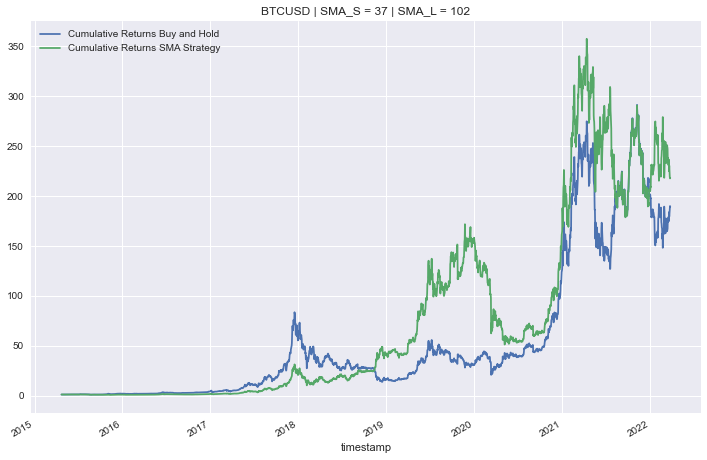

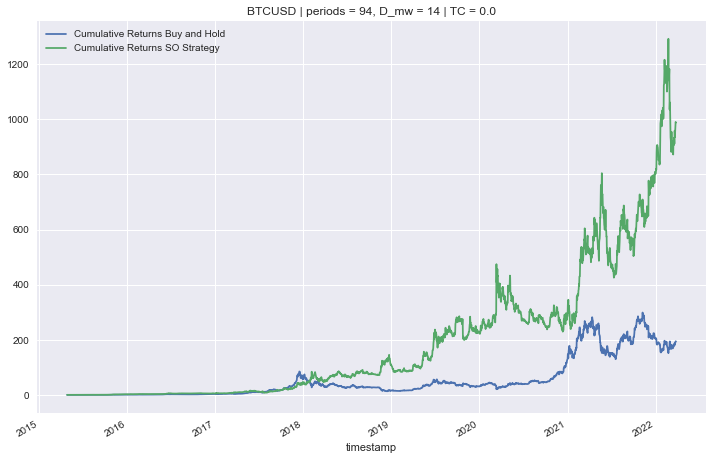

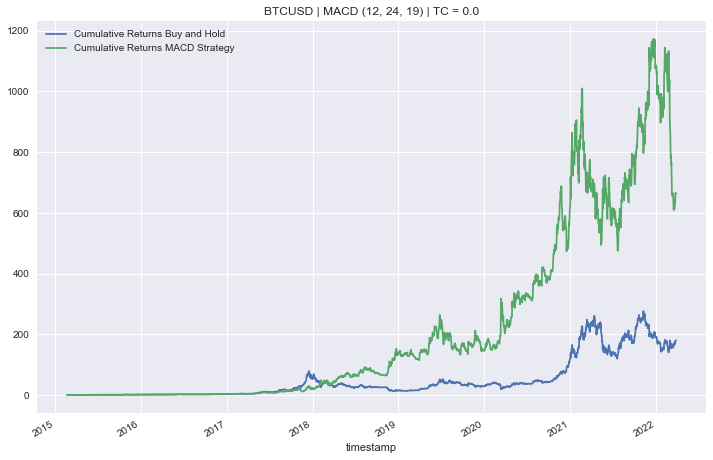

In [16]:
sma.plot_results()
so.plot_results()
macd.plot_results()

#### Review the Data Frame

Once a strategy is tested, the function def test_strategy stores the data within 'self.results = data'

In [17]:
# View SMA results as a dataframe
sma.results
sma_df= pd.DataFrame(sma.results)
sma_df

,close,returns,SMA_S,SMA_L,position,strategy,Cumulative Returns Buy and Hold,Cumulative Returns SMA Strategy
timestamp,,,,,,,,
2015-04-23 05:00:00+00:00,233.89,-0.000385,244.463784,245.640196,-1,0.000385,0.999615,1.000385
2015-04-24 05:00:00+00:00,230.39,-0.015077,243.767297,245.065686,-1,0.015077,0.984657,1.015582
2015-04-25 05:00:00+00:00,220.58,-0.043513,242.585405,244.679216,-1,0.043513,0.942730,1.060749
2015-04-26 05:00:00+00:00,220.14,-0.001997,241.418649,244.684216,-1,0.001997,0.940850,1.062869
2015-04-27 05:00:00+00:00,227.58,0.033238,240.491081,245.738922,-1,-0.033238,0.972647,1.028122
...,...,...,...,...,...,...,...,...
2022-03-22 05:00:00+00:00,41963.89,-0.024419,40194.972162,42273.884902,-1,0.024419,179.348192,230.421994
2022-03-23 05:00:00+00:00,42932.39,0.022817,40176.881351,42214.287549,-1,-0.022817,183.487435,225.223968
2022-03-24 05:00:00+00:00,44116.67,0.027211,40177.842162,42163.706176,-1,-0.027211,188.548893,219.177994


<AxesSubplot:xlabel='timestamp'>

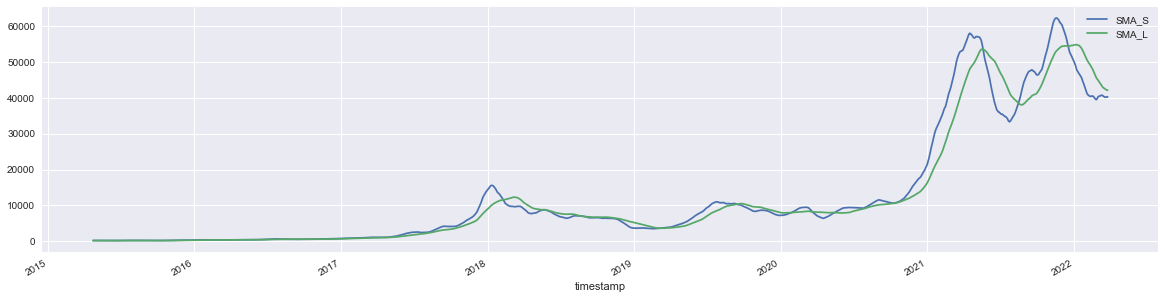

In [18]:
sma_df[['SMA_S','SMA_L']].plot(figsize = (20,5))

In [19]:
# View SO results as a dataframe
so.results
so_df = pd.DataFrame(so.results)
so_df

,exchange,open,high,low,close,volume,trade_count,vwap,returns,roll_low,roll_high,K,D,position,strategy,trades,Cumulative Returns Buy and Hold,Cumulative Returns SO Strategy
timestamp,,,,,,,,,,,,,,,,,,
2015-04-28 05:00:00+00:00,CBSE,225.69,227.55,220.46,225.64,5240.441591,8855,224.568781,-0.008561,216.16,322.72,8.896396,28.766981,-1,0.008561,0.0,0.991476,1.008598
2015-04-29 05:00:00+00:00,CBSE,225.78,227.05,225.10,226.46,1811.528904,3036,225.710251,0.003628,216.16,322.72,9.665916,25.615664,-1,-0.003628,0.0,0.995079,1.004946
2015-04-30 05:00:00+00:00,CBSE,236.78,238.78,235.66,236.52,1735.885889,4697,237.266107,0.043464,216.16,297.45,25.046131,23.399841,1,-0.043464,2.0,1.039283,0.962202
2015-05-01 05:00:00+00:00,CBSE,236.61,238.45,233.01,233.14,8233.330242,20257,235.457570,-0.014394,216.16,297.45,20.888178,21.074611,-1,-0.014394,2.0,1.024431,0.948452
2015-05-02 05:00:00+00:00,CBSE,235.94,237.51,234.26,236.63,1160.867237,2666,235.843926,0.014859,216.16,297.45,25.181449,19.033896,1,-0.014859,2.0,1.039766,0.934463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-22 05:00:00+00:00,CBSE,42268.14,43239.61,41766.79,41963.89,13845.719338,511776,42633.738855,-0.024419,32933.33,52025.00,47.301048,38.634366,1,-0.024419,0.0,184.391818,935.349873
2022-03-23 05:00:00+00:00,CBSE,41967.47,43296.47,41800.17,42932.39,15368.343539,567234,42496.030234,0.022817,32933.33,52025.00,52.373941,40.022859,1,0.022817,0.0,188.647465,956.937155
2022-03-24 05:00:00+00:00,CBSE,42932.44,44390.00,42627.48,44116.67,22090.426546,668029,43627.581639,0.027211,32933.33,52025.00,58.577065,42.018075,1,0.027211,0.0,193.851261,983.334044


In [20]:
# View MACD results as a dataframe
macd.results
macd_df = pd.DataFrame(macd.results)
macd_df

,close,returns,EMA_S,EMA_L,MACD,MACD_Signal,position,strategy,trades,Cumulative Returns Buy and Hold,Cumulative Returns MACD Strategy
timestamp,,,,,,,,,,,
2015-02-22 06:00:00+00:00,237.65,-0.035792,239.388262,236.553983,2.834279,1.101619,1,-0.035792,0.0,0.964841,0.964841
2015-02-23 06:00:00+00:00,239.19,0.006459,239.357741,236.770385,2.587356,1.268447,1,0.006459,0.0,0.971093,0.971093
2015-02-24 06:00:00+00:00,239.46,0.001128,239.373482,236.990724,2.382757,1.392050,1,0.001128,0.0,0.972190,0.972190
2015-02-25 06:00:00+00:00,237.50,-0.008219,239.085121,237.032365,2.052756,1.464546,1,-0.008219,0.0,0.964232,0.964232
2015-02-26 06:00:00+00:00,237.11,-0.001643,238.781138,237.038702,1.742436,1.494744,1,-0.001643,0.0,0.962649,0.962649
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-22 05:00:00+00:00,41963.89,-0.024419,41008.593527,40561.495299,447.098227,-20.434840,1,-0.024419,0.0,170.370225,628.930134
2022-03-23 05:00:00+00:00,42932.39,0.022817,41304.562215,40751.166875,553.395339,36.948178,1,0.022817,0.0,174.302261,643.445443
2022-03-24 05:00:00+00:00,44116.67,0.027211,41737.194182,41020.407125,716.787056,104.932066,1,0.027211,0.0,179.110349,661.194736


### Backtesting & Forward Testing

#### Training Set

In [21]:
# Lets train and optimize our parameters for only the beginning of 2019 to the end of 2020 on the SMA strategy
train_sma = SMA.SMABacktester(symbol, 50, 200, "2019-01-01", "2020-12-31",api_trade)

In [22]:
train_sma.optimize_parameters((25, 50, 1), (100, 200, 1)) # optimizing strategy & backtesting ("in-sample")

(array([ 33., 105.]), 3.552848)

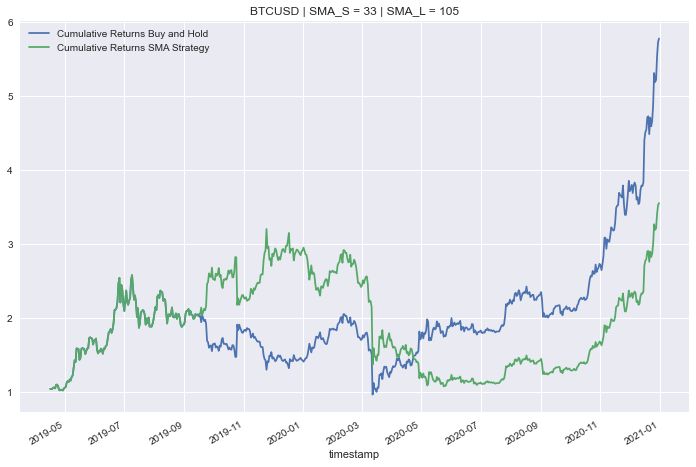

In [23]:
train_sma.plot_results()

### Test set

In [24]:
# Use the hyper parameters to see if the model that potentially minimized 
# our downside without any stop loss is a winning future strategy
tester_sma = SMA.SMABacktester(symbol, 33, 105, "2021-01-01", end, api_trade)

In [25]:
# Test the strategy, or an error is returned
# the outperformance / underperformance in an array
tester_sma.test_strategy() #("in-sample")

(0.562373, -0.933169)

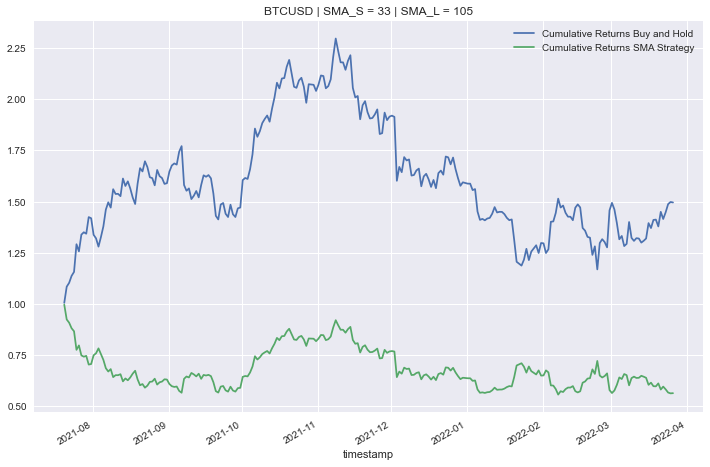

In [26]:
tester_sma.plot_results()

####  Repeating the same with the other 2 strategies

(array([19., 34., 19.]), 9.936117)

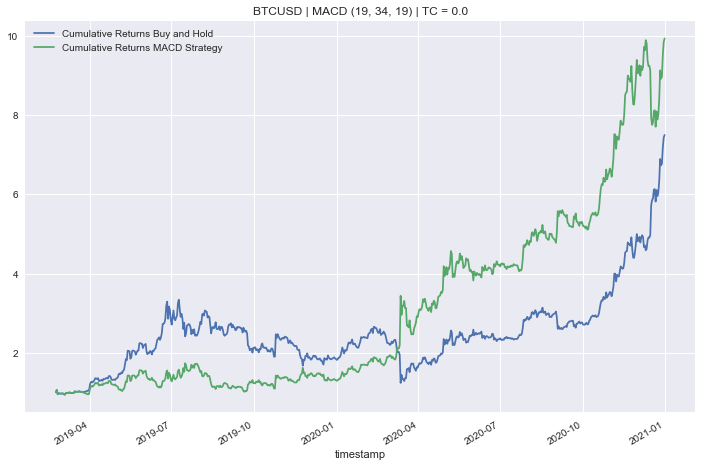

In [27]:
train_macd = MACD(symbol, EMA_S = ema_s, EMA_L = ema_l, signal_mw = signal_mw,start = "2019-01-01", end = "2020-12-31", tc = tc,api=api_trade)
display(train_macd.optimize_parameters((5, 20, 1), (21, 50, 1), (5, 20, 1)))
train_macd.plot_results()

(0.45128, -0.342422)

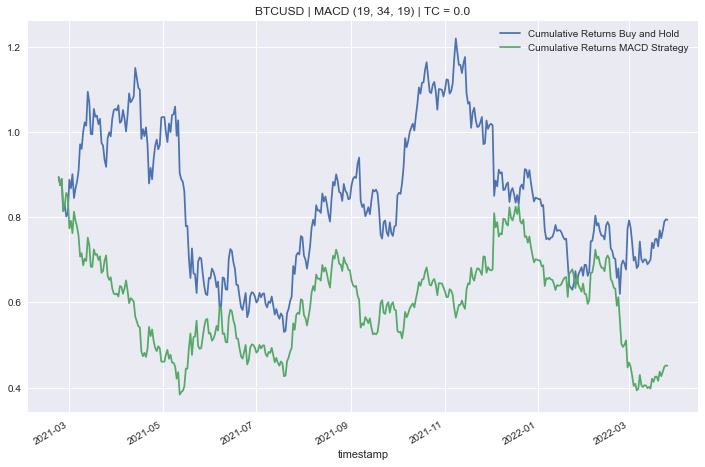

In [28]:
tester_macd = MACD(symbol, EMA_S = 19, EMA_L = 34, signal_mw = 19,start = "2021-01-01", end = end,tc = tc,api=api_trade)
display(tester_macd.test_strategy()) # forward testing ("out-sample")
tester_macd.plot_results()

(array([56., 14.]), 5.201904)

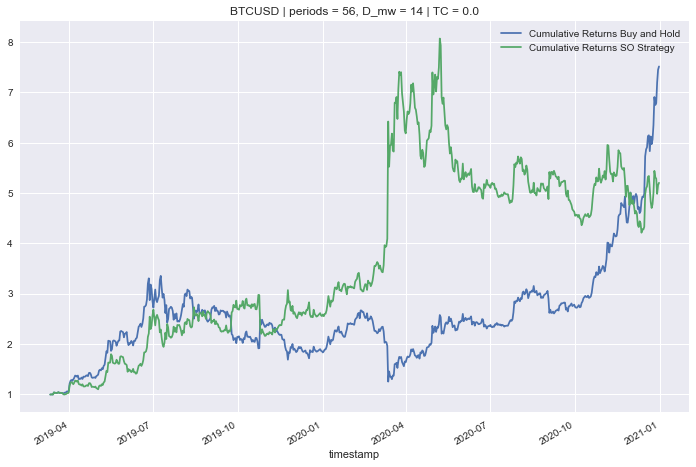

In [29]:
train_SO = SO(symbol, periods, d_mw,"2019-01-01","2020-12-31",tc,api_trade)
# train_SO.test_strategy()
display(train_SO.optimize_parameters((10, 100, 1), (3, 50, 1)))
train_SO.plot_results()

(1.201618, 0.407785)

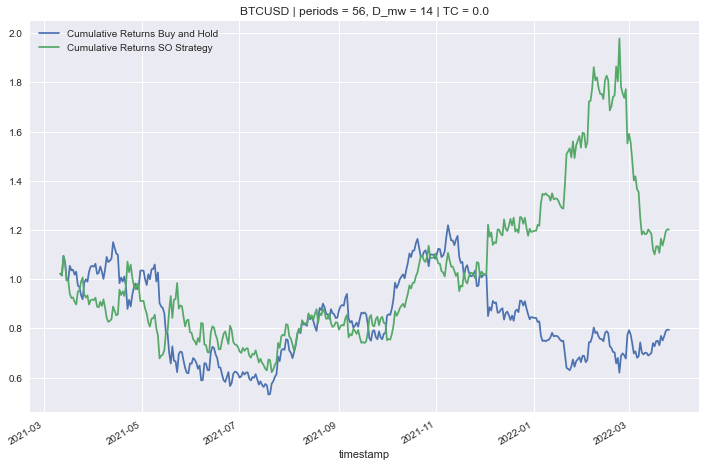

In [30]:
tester_SO = SO(symbol, 56, 14,"2021-01-01",end,tc,api_trade)

# The test_strategy function will output the cumulative return of $1 dollar invested
display(tester_SO.test_strategy()) # forward testing ("out-sample")
tester_SO.plot_results()

#### First Conclusion

In [31]:
# Test strategy returns (absolute performance, what is the evolution of $1 throughout our time period to the end
# and the difference in the buy and hold strategy)
# SO Strategy
tester_SO.test_strategy()

(1.201618, 0.407785)

In [32]:
# MACD Strategy
tester_macd.test_strategy()

(0.45128, -0.342422)

In [33]:
# SMA Strategy
tester_sma.test_strategy()

(0.562373, -0.933169)

Reviewing the test results, over time, the strategy can provide results that would under perform the market in certain strategies (such as MACD, AND SMA, and outperform such as in the SO, therefore:

1) We may not be able to rely directly on the backtesting alone of these strategies EVEN with optimized parameters using the brute force method. 
2) Utilizing a singular technical strategy may not be benefical.
3) However, the strategy should be updated and optimized periodically to produce better results.
4) It may be considered to combine strategies for more true signals, or build a function to minimize downside itself to preserve capital.

### Begin Modeling Data

In [34]:
#Now with the data, 
macd_df.tail()

,close,returns,EMA_S,EMA_L,MACD,MACD_Signal,position,strategy,trades,Cumulative Returns Buy and Hold,Cumulative Returns MACD Strategy
timestamp,,,,,,,,,,,
2022-03-22 05:00:00+00:00,41963.89,-0.024419,41008.593527,40561.495299,447.098227,-20.434840,1,-0.024419,0.0,170.370225,628.930134
2022-03-23 05:00:00+00:00,42932.39,0.022817,41304.562215,40751.166875,553.395339,36.948178,1,0.022817,0.0,174.302261,643.445443
2022-03-24 05:00:00+00:00,44116.67,0.027211,41737.194182,41020.407125,716.787056,104.932066,1,0.027211,0.0,179.110349,661.194736
2022-03-25 05:00:00+00:00,44433.32,0.007152,42151.982769,41293.440155,858.542614,180.293120,1,0.007152,0.0,180.395924,665.940501
2022-03-26 05:00:00+00:00,44332.08,-0.002281,42487.382343,41536.531343,950.851000,257.348908,1,-0.002281,0.0,179.984897,664.423175


In [35]:
# Creating a technical indicator feature set that includes the close price
macd_feat = macd_df[['close','EMA_S','EMA_L','MACD','MACD_Signal']]
so_feat = so_df[['vwap','K','D']]
sma_feat = sma_df[['SMA_L','SMA_S']]

In [36]:
macd_feat

,close,EMA_S,EMA_L,MACD,MACD_Signal
timestamp,,,,,
2015-02-22 06:00:00+00:00,237.65,239.388262,236.553983,2.834279,1.101619
2015-02-23 06:00:00+00:00,239.19,239.357741,236.770385,2.587356,1.268447
2015-02-24 06:00:00+00:00,239.46,239.373482,236.990724,2.382757,1.392050
2015-02-25 06:00:00+00:00,237.50,239.085121,237.032365,2.052756,1.464546
2015-02-26 06:00:00+00:00,237.11,238.781138,237.038702,1.742436,1.494744
...,...,...,...,...,...
2022-03-22 05:00:00+00:00,41963.89,41008.593527,40561.495299,447.098227,-20.434840
2022-03-23 05:00:00+00:00,42932.39,41304.562215,40751.166875,553.395339,36.948178
2022-03-24 05:00:00+00:00,44116.67,41737.194182,41020.407125,716.787056,104.932066


In [37]:
so_feat

,vwap,K,D
timestamp,,,
2015-04-28 05:00:00+00:00,224.568781,8.896396,28.766981
2015-04-29 05:00:00+00:00,225.710251,9.665916,25.615664
2015-04-30 05:00:00+00:00,237.266107,25.046131,23.399841
2015-05-01 05:00:00+00:00,235.457570,20.888178,21.074611
2015-05-02 05:00:00+00:00,235.843926,25.181449,19.033896
...,...,...,...
2022-03-22 05:00:00+00:00,42633.738855,47.301048,38.634366
2022-03-23 05:00:00+00:00,42496.030234,52.373941,40.022859
2022-03-24 05:00:00+00:00,43627.581639,58.577065,42.018075


In [38]:
sma_feat

,SMA_L,SMA_S
timestamp,,
2015-04-23 05:00:00+00:00,245.640196,244.463784
2015-04-24 05:00:00+00:00,245.065686,243.767297
2015-04-25 05:00:00+00:00,244.679216,242.585405
2015-04-26 05:00:00+00:00,244.684216,241.418649
2015-04-27 05:00:00+00:00,245.738922,240.491081
...,...,...
2022-03-22 05:00:00+00:00,42273.884902,40194.972162
2022-03-23 05:00:00+00:00,42214.287549,40176.881351
2022-03-24 05:00:00+00:00,42163.706176,40177.842162


In [39]:
dfc = pd.concat((macd_feat,so_feat,sma_feat), axis=1)

In [40]:
dfc = dfc.dropna()
dfc

,close,EMA_S,EMA_L,MACD,MACD_Signal,vwap,K,D,SMA_L,SMA_S
timestamp,,,,,,,,,,
2015-04-28 05:00:00+00:00,225.64,227.967433,233.214718,-5.247285,-5.654603,224.568781,8.896396,28.766981,245.948922,239.311081
2015-04-29 05:00:00+00:00,226.46,227.735520,232.674279,-4.938759,-5.583010,225.710251,9.665916,25.615664,246.213627,238.201081
2015-04-30 05:00:00+00:00,236.52,229.086978,232.981969,-3.894990,-5.414191,237.266107,25.046131,23.399841,246.728529,237.878378
2015-05-01 05:00:00+00:00,233.14,229.710520,232.994612,-3.284092,-5.201161,235.457570,20.888178,21.074611,246.803333,237.537838
2015-05-02 05:00:00+00:00,236.63,230.775056,233.285469,-2.510414,-4.932063,235.843926,25.181449,19.033896,246.985980,237.207568
...,...,...,...,...,...,...,...,...,...,...
2022-03-22 05:00:00+00:00,41963.89,41008.593527,40561.495299,447.098227,-20.434840,42633.738855,47.301048,38.634366,42273.884902,40194.972162
2022-03-23 05:00:00+00:00,42932.39,41304.562215,40751.166875,553.395339,36.948178,42496.030234,52.373941,40.022859,42214.287549,40176.881351
2022-03-24 05:00:00+00:00,44116.67,41737.194182,41020.407125,716.787056,104.932066,43627.581639,58.577065,42.018075,42163.706176,40177.842162


### Loading / Fetching Stock,Ethereum (ETHUSD) and litecoin (LTCUSD) close prices as well as BTC Has Rate data

In [41]:
# Filter for the close, send to da dataframe, and convert the datetime index

# Ethereum (ETHUSD)
eth_df = api_trade.get_crypto_bars('ETHUSD', TimeFrame.Day, "2016-08-16", "2022-06-09", exchanges=['CBSE']).df
eth_df = eth_df['close']
eth_df = eth_df.to_frame(name='ETH')
eth_df.index = pd.to_datetime(eth_df.index, format = '%m/%d/%Y').strftime('%Y-%m-%d')
eth_df.index = pd.to_datetime(eth_df.index)

# litecoin (LTCUSD)
ltc_df = api_trade.get_crypto_bars('LTCUSD', TimeFrame.Day, "2016-08-16", "2022-06-09", exchanges=['CBSE']).df
ltc_df = ltc_df['close']
ltc_df = ltc_df.to_frame(name='LTC')
ltc_df.index = pd.to_datetime(ltc_df.index, format = '%m/%d/%Y').strftime('%Y-%m-%d')
ltc_df.index = pd.to_datetime(ltc_df.index)

In [42]:
# Why arbitratry date, only limiitations when requesteing daily data (Litecoin data via coinbase [CBSE] goes back to 2016-08-16
# Get the start date
start = "2009-01-03" # Bitcoin's genesis block date, we wont get all data limited by alpaca

# Ethereum (ETHUSD)
eth_x = api_trade.get_crypto_bars('ETHUSD', TimeFrame.Day, start, "2022-06-09", exchanges=['CBSE']).df
eth_x = eth_x['close']
eth_x = eth_x.to_frame(name='ETH')
eth_x.index = pd.to_datetime(eth_x.index, format = '%m/%d/%Y').strftime('%Y-%m-%d')
eth_x.index = pd.to_datetime(eth_x.index)

# litecoin (LTCUSD)
ltc_x = api_trade.get_crypto_bars('LTCUSD', TimeFrame.Day, start, "2022-06-09", exchanges=['CBSE']).df
ltc_x = ltc_x['close']
ltc_x = ltc_x.to_frame(name='LTC')
ltc_x.index = pd.to_datetime(ltc_x.index, format = '%m/%d/%Y').strftime('%Y-%m-%d')
ltc_x.index = pd.to_datetime(ltc_x.index)

In [43]:
# View Dataframes that have a start date of bitcoins hash rate data, what is start and end
# litecoin has the earliest date 8-16-2016
display(eth_x)
display(ltc_x)

,ETH
timestamp,
2016-05-17,14.00
2016-05-18,13.18
2016-05-19,14.82
2016-05-20,14.17
2016-05-23,13.74
...,...
2022-03-22,2939.32
2022-03-23,3028.11
2022-03-24,3146.32


,LTC
timestamp,
2016-08-16,3.70
2016-08-17,3.62
2016-08-18,3.70
2016-08-19,3.75
2016-08-21,4.00
...,...
2022-03-22,119.81
2022-03-23,121.70
2022-03-24,127.25


In [44]:
# View Dataframes, these are filtered for 8-16-2016
display(eth_df)
display(ltc_df)

,ETH
timestamp,
2016-08-16,11.18
2016-08-17,10.93
2016-08-18,10.80
2016-08-19,11.07
2016-08-20,11.30
...,...
2022-03-22,2939.32
2022-03-23,3028.11
2022-03-24,3146.32


,LTC
timestamp,
2016-08-16,3.70
2016-08-17,3.62
2016-08-18,3.70
2016-08-19,3.75
2016-08-21,4.00
...,...
2022-03-22,119.81
2022-03-23,121.70
2022-03-24,127.25


In [45]:
# Load in bitcoin hash rate data
hr_data = pd.read_csv("hash-rate.csv", parse_dates = ["Date"], index_col = "Date")

# Check if the type of date type index is datetime64
hr_data.index.inferred_type == "datetime64"

# Filter to 8/16/2016, this is due to data limitations in Alpaca API, and for the latest date available when utilizing the API
hr_data = hr_data["2016-08-16":]

# View Has Rate data
hr_data

,TH/s
Date,
2016-08-16,1.469588e+06
2016-08-17,1.329113e+06
2016-08-18,1.664092e+06
2016-08-19,1.664092e+06
2016-08-20,1.685704e+06
...,...
2022-03-17,2.175230e+08
2022-03-18,1.951495e+08
2022-03-19,2.115256e+08


In [46]:
# Pull in Nvidia data
nvda = pd.read_csv("NVDA.csv", parse_dates = ["Date"], index_col = "Date")
nvda = nvda["2016-08-16":]
nvda

,NVDA
Date,
2016-08-16,15.650000
2016-08-17,15.287500
2016-08-18,15.525000
2016-08-19,15.565000
2016-08-22,15.630000
...,...
2022-03-15,229.729996
2022-03-16,244.960007
2022-03-17,247.660004


### Cleaning the data

In [47]:
# Convert the index from a timestampe to datetime index
dfc.index = pd.to_datetime(dfc.index, format = '%m/%d/%Y').strftime('%Y-%m-%d')
dfc

,close,EMA_S,EMA_L,MACD,MACD_Signal,vwap,K,D,SMA_L,SMA_S
timestamp,,,,,,,,,,
2015-04-28,225.64,227.967433,233.214718,-5.247285,-5.654603,224.568781,8.896396,28.766981,245.948922,239.311081
2015-04-29,226.46,227.735520,232.674279,-4.938759,-5.583010,225.710251,9.665916,25.615664,246.213627,238.201081
2015-04-30,236.52,229.086978,232.981969,-3.894990,-5.414191,237.266107,25.046131,23.399841,246.728529,237.878378
2015-05-01,233.14,229.710520,232.994612,-3.284092,-5.201161,235.457570,20.888178,21.074611,246.803333,237.537838
2015-05-02,236.63,230.775056,233.285469,-2.510414,-4.932063,235.843926,25.181449,19.033896,246.985980,237.207568
...,...,...,...,...,...,...,...,...,...,...
2022-03-22,41963.89,41008.593527,40561.495299,447.098227,-20.434840,42633.738855,47.301048,38.634366,42273.884902,40194.972162
2022-03-23,42932.39,41304.562215,40751.166875,553.395339,36.948178,42496.030234,52.373941,40.022859,42214.287549,40176.881351
2022-03-24,44116.67,41737.194182,41020.407125,716.787056,104.932066,43627.581639,58.577065,42.018075,42163.706176,40177.842162


In [48]:
# All index types should be datetime64 to concat correctly, the dfs dataframe is not in the correct format
display(dfc.index.inferred_type == "datetime64")
display(hr_data.index.inferred_type == "datetime64")
display(nvda.index.inferred_type == "datetime64")

False

True

True

In [49]:
# Use to_datetime to change the format to match our other dataframes
dfc.index = pd.to_datetime(dfc.index)
display(dfc.index.inferred_type == "datetime64")

True

In [50]:
dfc

,close,EMA_S,EMA_L,MACD,MACD_Signal,vwap,K,D,SMA_L,SMA_S
timestamp,,,,,,,,,,
2015-04-28,225.64,227.967433,233.214718,-5.247285,-5.654603,224.568781,8.896396,28.766981,245.948922,239.311081
2015-04-29,226.46,227.735520,232.674279,-4.938759,-5.583010,225.710251,9.665916,25.615664,246.213627,238.201081
2015-04-30,236.52,229.086978,232.981969,-3.894990,-5.414191,237.266107,25.046131,23.399841,246.728529,237.878378
2015-05-01,233.14,229.710520,232.994612,-3.284092,-5.201161,235.457570,20.888178,21.074611,246.803333,237.537838
2015-05-02,236.63,230.775056,233.285469,-2.510414,-4.932063,235.843926,25.181449,19.033896,246.985980,237.207568
...,...,...,...,...,...,...,...,...,...,...
2022-03-22,41963.89,41008.593527,40561.495299,447.098227,-20.434840,42633.738855,47.301048,38.634366,42273.884902,40194.972162
2022-03-23,42932.39,41304.562215,40751.166875,553.395339,36.948178,42496.030234,52.373941,40.022859,42214.287549,40176.881351
2022-03-24,44116.67,41737.194182,41020.407125,716.787056,104.932066,43627.581639,58.577065,42.018075,42163.706176,40177.842162


In [51]:
# Filter to 8/16/2016, this is due to data limitations in Alpaca API, and for the latest date available when utilizing the API
dfc = dfc["2016-08-16":]
dfc

,close,EMA_S,EMA_L,MACD,MACD_Signal,vwap,K,D,SMA_L,SMA_S
timestamp,,,,,,,,,,
2016-08-16,579.02,586.021449,601.881782,-15.860333,-13.328243,575.255791,41.842566,43.333611,598.307353,626.632973
2016-08-17,574.46,584.242764,599.688039,-15.445275,-13.539946,574.604827,40.513120,43.356518,599.410784,624.600000
2016-08-18,575.06,582.830031,597.717796,-14.887765,-13.674728,574.628338,40.688047,43.097459,600.521569,622.181892
2016-08-19,573.67,581.420796,595.793972,-14.373177,-13.744573,574.987659,40.282799,42.903165,601.595196,620.022162
2016-08-20,582.16,581.534519,594.703254,-13.168735,-13.686989,582.043909,42.758017,42.681799,602.827745,617.756757
...,...,...,...,...,...,...,...,...,...,...
2022-03-22,41963.89,41008.593527,40561.495299,447.098227,-20.434840,42633.738855,47.301048,38.634366,42273.884902,40194.972162
2022-03-23,42932.39,41304.562215,40751.166875,553.395339,36.948178,42496.030234,52.373941,40.022859,42214.287549,40176.881351
2022-03-24,44116.67,41737.194182,41020.407125,716.787056,104.932066,43627.581639,58.577065,42.018075,42163.706176,40177.842162


In [52]:
# Check if there are any NaN 
display(dfc.isna().sum())
display(nvda.isna().sum())
display(eth_df.isna().sum())
display(ltc_df.isna().sum())

close          0
EMA_S          0
EMA_L          0
MACD           0
MACD_Signal    0
vwap           0
K              0
D              0
SMA_L          0
SMA_S          0
dtype: int64

NVDA    0
dtype: int64

ETH    0
dtype: int64

LTC    0
dtype: int64

In [53]:
# All index types should be datetime64 to concat correctly, the dfs dataframe is not in the correct format
display(dfc.index.inferred_type == "datetime64")
display(hr_data.index.inferred_type == "datetime64")
display(nvda.index.inferred_type == "datetime64")
display(eth_df.index.inferred_type == "datetime64")
display(ltc_df.index.inferred_type == "datetime64")

True

True

True

True

True

In [54]:
merged_df = pd.concat([dfc,hr_data, nvda, ltc_df,eth_df],axis=1)

In [55]:
merged_df

,close,EMA_S,EMA_L,MACD,MACD_Signal,vwap,K,D,SMA_L,SMA_S,TH/s,NVDA,LTC,ETH
2016-08-16,579.02,586.021449,601.881782,-15.860333,-13.328243,575.255791,41.842566,43.333611,598.307353,626.632973,1469587.960,15.6500,3.70,11.18
2016-08-17,574.46,584.242764,599.688039,-15.445275,-13.539946,574.604827,40.513120,43.356518,599.410784,624.600000,1329112.640,15.2875,3.62,10.93
2016-08-18,575.06,582.830031,597.717796,-14.887765,-13.674728,574.628338,40.688047,43.097459,600.521569,622.181892,1664092.254,15.5250,3.70,10.80
2016-08-19,573.67,581.420796,595.793972,-14.373177,-13.744573,574.987659,40.282799,42.903165,601.595196,620.022162,1664092.250,15.5650,3.75,11.07
2016-08-20,582.16,581.534519,594.703254,-13.168735,-13.686989,582.043909,42.758017,42.681799,602.827745,617.756757,1685703.840,NaN,NaN,11.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-22,41963.89,41008.593527,40561.495299,447.098227,-20.434840,42633.738855,47.301048,38.634366,42273.884902,40194.972162,NaN,NaN,119.81,2939.32
2022-03-23,42932.39,41304.562215,40751.166875,553.395339,36.948178,42496.030234,52.373941,40.022859,42214.287549,40176.881351,NaN,NaN,121.70,3028.11
2022-03-24,44116.67,41737.194182,41020.407125,716.787056,104.932066,43627.581639,58.577065,42.018075,42163.706176,40177.842162,NaN,NaN,127.25,3146.32
2022-03-25,44433.32,42151.982769,41293.440155,858.542614,180.293120,44451.159423,60.235642,43.984231,42141.388137,40199.258108,NaN,NaN,124.24,3113.85


In [56]:
merged_df.to_csv('testset.csv')

### Linear Interpolation in forwarding Direction
The linear method ignores the index and treats missing values as equally spaced and finds the best point to fit the missing value after previous points. [Linear Interpolation](https://www.analyticsvidhya.com/blog/2021/06/power-of-interpolation-in-python-to-fill-missing-values/) simply means to estimate a missing value by connecting dots in a straight line in increasing order. If the missing value is at first index then it will leave it as Nan. let’s apply it to our dataframe.

In [57]:
# Because stock data (trades 5 days a week), and crypto (trades 7 days a week every week), a deliberate choice is made to leave in NaN
# To do this we choose linear interpolation
merged_df = merged_df.reindex()
merged_df

,close,EMA_S,EMA_L,MACD,MACD_Signal,vwap,K,D,SMA_L,SMA_S,TH/s,NVDA,LTC,ETH
2016-08-16,579.02,586.021449,601.881782,-15.860333,-13.328243,575.255791,41.842566,43.333611,598.307353,626.632973,1469587.960,15.6500,3.70,11.18
2016-08-17,574.46,584.242764,599.688039,-15.445275,-13.539946,574.604827,40.513120,43.356518,599.410784,624.600000,1329112.640,15.2875,3.62,10.93
2016-08-18,575.06,582.830031,597.717796,-14.887765,-13.674728,574.628338,40.688047,43.097459,600.521569,622.181892,1664092.254,15.5250,3.70,10.80
2016-08-19,573.67,581.420796,595.793972,-14.373177,-13.744573,574.987659,40.282799,42.903165,601.595196,620.022162,1664092.250,15.5650,3.75,11.07
2016-08-20,582.16,581.534519,594.703254,-13.168735,-13.686989,582.043909,42.758017,42.681799,602.827745,617.756757,1685703.840,NaN,NaN,11.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-22,41963.89,41008.593527,40561.495299,447.098227,-20.434840,42633.738855,47.301048,38.634366,42273.884902,40194.972162,NaN,NaN,119.81,2939.32
2022-03-23,42932.39,41304.562215,40751.166875,553.395339,36.948178,42496.030234,52.373941,40.022859,42214.287549,40176.881351,NaN,NaN,121.70,3028.11
2022-03-24,44116.67,41737.194182,41020.407125,716.787056,104.932066,43627.581639,58.577065,42.018075,42163.706176,40177.842162,NaN,NaN,127.25,3146.32
2022-03-25,44433.32,42151.982769,41293.440155,858.542614,180.293120,44451.159423,60.235642,43.984231,42141.388137,40199.258108,NaN,NaN,124.24,3113.85


In [58]:
merged_df = merged_df.interpolate(method ='linear', limit_direction ='forward')
merged_df

,close,EMA_S,EMA_L,MACD,MACD_Signal,vwap,K,D,SMA_L,SMA_S,TH/s,NVDA,LTC,ETH
2016-08-16,579.02,586.021449,601.881782,-15.860333,-13.328243,575.255791,41.842566,43.333611,598.307353,626.632973,1.469588e+06,15.650000,3.700,11.18
2016-08-17,574.46,584.242764,599.688039,-15.445275,-13.539946,574.604827,40.513120,43.356518,599.410784,624.600000,1.329113e+06,15.287500,3.620,10.93
2016-08-18,575.06,582.830031,597.717796,-14.887765,-13.674728,574.628338,40.688047,43.097459,600.521569,622.181892,1.664092e+06,15.525000,3.700,10.80
2016-08-19,573.67,581.420796,595.793972,-14.373177,-13.744573,574.987659,40.282799,42.903165,601.595196,620.022162,1.664092e+06,15.565000,3.750,11.07
2016-08-20,582.16,581.534519,594.703254,-13.168735,-13.686989,582.043909,42.758017,42.681799,602.827745,617.756757,1.685704e+06,15.586667,3.875,11.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-22,41963.89,41008.593527,40561.495299,447.098227,-20.434840,42633.738855,47.301048,38.634366,42273.884902,40194.972162,2.087963e+08,267.339996,119.810,2939.32
2022-03-23,42932.39,41304.562215,40751.166875,553.395339,36.948178,42496.030234,52.373941,40.022859,42214.287549,40176.881351,2.087963e+08,267.339996,121.700,3028.11
2022-03-24,44116.67,41737.194182,41020.407125,716.787056,104.932066,43627.581639,58.577065,42.018075,42163.706176,40177.842162,2.087963e+08,267.339996,127.250,3146.32
2022-03-25,44433.32,42151.982769,41293.440155,858.542614,180.293120,44451.159423,60.235642,43.984231,42141.388137,40199.258108,2.087963e+08,267.339996,124.240,3113.85


In [59]:
# Check again for NaN's and now nice and neat
merged_df.isna().sum()

close          0
EMA_S          0
EMA_L          0
MACD           0
MACD_Signal    0
vwap           0
K              0
D              0
SMA_L          0
SMA_S          0
TH/s           0
NVDA           0
LTC            0
ETH            0
dtype: int64

#### Augmented Dickey Fuller Test for Stationarity
If it is false, the data is non-stationary. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series to make the data stationary while building the Auto ARIMA model. In the models we will use the differencing or (d) factor is the p,d,q order that can go in as input into models we will use.

In [60]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(merged_df['close'])

(0.5347603830013153, True)

## Creating Logarithm Returns
["For normal person like me, it probably doesn’t matter which return I use.](https://medium.com/@huangchingchiu/analysis-on-stocks-log-1-return-or-simple-return-371c3f60fab2) It’s unlikely that I would use a sophisticated portfolio risk management model to monitor my portfolio. Hence, I would probably still use log(1+return) for the normal distribution property, which fits better to the assumptions of lots of pricing models, while keeping in mind that it may fail in estimating moments of the portfolio."

In [61]:
# Calculate % Change
merged_df_lr = np.log1p(merged_df.pct_change()).mul(100)

In [62]:
# Filter and use backfill method - note close column represents log returns
merged_df_lr = merged_df_lr.iloc[1:,]
merged_df_lr = merged_df_lr.fillna(method='bfill',axis=1)
merged_df_lr

,close,EMA_S,EMA_L,MACD,MACD_Signal,vwap,K,D,SMA_L,SMA_S,TH/s,NVDA,LTC,ETH
2016-08-17,-0.790655,-0.303980,-0.365146,-2.651809,1.575897,-0.113225,-3.228828,0.052848,0.184256,-0.324955,-1.004705e+01,-2.343542,-2.185879,-2.261517
2016-08-18,0.104391,-0.242099,-0.329086,-3.676341,0.990516,0.004092,0.430849,-0.599300,0.185141,-0.387896,2.247683e+01,1.541613,2.185879,-1.196517
2016-08-19,-0.242007,-0.242085,-0.322381,-3.517598,0.509458,0.062511,-1.000981,-0.451844,0.178623,-0.347726,-2.403713e-07,0.257318,1.342302,2.469261
2016-08-20,1.469101,0.019558,-0.183237,-8.751827,-0.419837,1.219731,5.963217,-0.517303,0.204671,-0.366044,1.290341e+00,0.139104,3.278982,2.056398
2016-08-21,-0.307949,-0.030812,-0.192998,-7.630857,-1.091460,-0.169588,-3.062883,-0.852772,0.204739,-0.381837,4.389419e+00,0.138911,3.174870,-0.354610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-22,-2.441923,0.424446,0.301101,12.299340,-126.472960,2.778182,-10.873776,0.426189,-0.147984,0.011816,0.000000e+00,0.000000,-0.258409,-2.989579
2022-03-23,2.281707,0.719132,0.466525,21.329433,-0.323527,-0.323527,10.187671,3.530856,-0.141079,-0.045018,0.000000e+00,0.000000,1.565185,2.976040
2022-03-24,2.721116,1.041972,0.658520,25.870616,104.379682,2.627889,11.193408,4.864911,-0.119892,0.002391,0.000000e+00,0.000000,4.459466,3.829485
2022-03-25,0.715192,0.988905,0.663398,18.045751,54.127083,1.870149,2.792099,4.573132,-0.052946,0.053289,0.000000e+00,0.000000,-2.393848,-1.037361


In [63]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(merged_df_lr['close'])

(0.01, False)

From the above, we can conclude that the data is non-stationary. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series to make the data stationary while building the Auto ARIMA model.

### Getting Dataset Ready for Model

In [64]:
## Splitting the Data Set for testing and training
size = int(len(merged_df_lr)*0.99)
df, df_test = merged_df_lr.iloc[:size], merged_df_lr.iloc[size:]

In [65]:
# View training set (2016-08-16 - 2022-02-28)
df

,close,EMA_S,EMA_L,MACD,MACD_Signal,vwap,K,D,SMA_L,SMA_S,TH/s,NVDA,LTC,ETH
2016-08-17,-0.790655,-0.303980,-0.365146,-2.651809,1.575897,-0.113225,-3.228828,0.052848,0.184256,-0.324955,-1.004705e+01,-2.343542,-2.185879,-2.261517
2016-08-18,0.104391,-0.242099,-0.329086,-3.676341,0.990516,0.004092,0.430849,-0.599300,0.185141,-0.387896,2.247683e+01,1.541613,2.185879,-1.196517
2016-08-19,-0.242007,-0.242085,-0.322381,-3.517598,0.509458,0.062511,-1.000981,-0.451844,0.178623,-0.347726,-2.403713e-07,0.257318,1.342302,2.469261
2016-08-20,1.469101,0.019558,-0.183237,-8.751827,-0.419837,1.219731,5.963217,-0.517303,0.204671,-0.366044,1.290341e+00,0.139104,3.278982,2.056398
2016-08-21,-0.307949,-0.030812,-0.192998,-7.630857,-1.091460,-0.169588,-3.062883,-0.852772,0.204739,-0.381837,4.389419e+00,0.138911,3.174870,-0.354610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-01,2.466388,1.834849,0.863908,-237.803401,-9.434536,6.835357,9.974244,2.954574,-0.307664,0.616959,5.064373e+00,-3.794698,0.594580,2.977223
2022-03-02,-2.194500,1.164273,0.598750,-16.589990,-16.589990,0.088852,-8.837142,2.195349,-0.342526,0.490375,-1.749414e+01,3.115749,-1.803459,-3.510095
2022-03-03,-4.648924,0.235823,0.160726,15.087746,-18.943448,-3.806070,-20.968469,1.420855,-0.351964,0.250944,8.042005e+00,-2.111314,-3.782349,-6.205192
2022-03-04,-5.863086,-0.690500,-0.316727,-117.155260,-13.602576,-5.103764,-32.236087,-0.836706,-0.384674,0.202155,-7.361711e+00,-3.335785,-4.879484,-3.685439


In [66]:
# View test set (2022-03-01 - Today)
df_test

,close,EMA_S,EMA_L,MACD,MACD_Signal,vwap,K,D,SMA_L,SMA_S,TH/s,NVDA,LTC,ETH
2022-03-06,-3.781110,-0.905119,-0.472550,249.806221,-0.530631,-2.121797,-25.263116,-0.759857,-0.422452,0.023532,6.301297,-2.384506,-4.048817,-4.621804
2022-03-07,0.835177,-0.648873,-0.373031,45.585319,4.897884,-0.446702,31.936109,4.035897,-0.433385,0.013569,12.201495,-2.442756,0.341229,-0.254401
2022-03-08,7.949212,0.674194,0.289201,-71.975006,-3.083851,2.615248,46.097959,7.028013,-0.284595,0.299919,0.000000,0.755845,6.167901,7.288368
2022-03-09,-5.707225,-0.316937,-0.193037,29.188489,-0.385354,5.533163,-31.214250,6.599715,-0.339811,0.049530,-6.995859,6.739884,-4.745345,-4.608200
2022-03-10,-1.121453,-0.438133,-0.265350,30.078155,2.994432,-6.039669,-7.209891,2.328924,-0.417778,0.023594,4.948006,-1.558972,0.610539,-1.030024
2022-03-11,1.011580,-0.219142,-0.165732,7.605399,3.589838,-0.102533,6.522562,2.261376,-0.386005,0.143477,-4.948006,-2.493539,5.016366,0.959806
2022-03-12,-0.125864,-0.204959,-0.162603,5.595017,3.856302,0.000109,-0.792269,2.508197,-0.400187,0.103715,12.260232,-1.168184,-1.107889,-0.247698
2022-03-13,-1.528405,-0.405142,-0.269150,16.238089,5.607732,-1.745799,-10.069955,2.370096,-0.418547,-0.200759,-3.257617,-1.181992,-2.320910,-0.545859
2022-03-14,0.669114,-0.242823,-0.196100,4.895362,5.501853,1.456873,4.514708,-1.861210,-0.410213,-0.187464,1.315808,-1.196130,1.315114,-0.916439
2022-03-15,0.863048,-0.074175,-0.112875,-4.311249,4.107143,1.232184,5.578971,-2.430994,-0.191527,-0.247176,-9.596399,7.420505,1.166166,2.826074


### ARMAX

In [67]:
# Test the entire test days
start_date = df.index[-1].strftime('%Y-%m-%d')
end_date = df_test.index[-1].strftime('%Y-%m-%d')

In [68]:
# Show start and end dates
display(start_date)
display(end_date)

'2022-03-05'

'2022-03-26'

In [69]:
# Using the from statsmodels.tsa.arima_model import ARIMA, lets fit an Auto Regressive, moving average model, 
# with x features (exogenous factors)

#We can adjust the parameters of p,d,q to see its impact on modeling
model_ret_armax = ARIMA(df.close, exog = df.iloc[:, 1:], order = (2,0,2))
results_ret_armax = model_ret_armax.fit()

In [70]:
# from the model ran we can retrieve specific criterions such as the AIC
results_ret_armax.aic

6809.9308067909315

In [71]:
# As well as viewing the predicted values
results_ret_armax.fittedvalues 

2016-08-17   -0.152748
2016-08-18    0.310772
2016-08-19    0.179111
2016-08-20    1.548549
2016-08-21   -0.108217
                ...   
2022-03-01    1.778943
2022-03-02   -0.571620
2022-03-03   -2.191560
2022-03-04   -2.777973
2022-03-05    0.871851
Freq: D, Length: 2027, dtype: float64

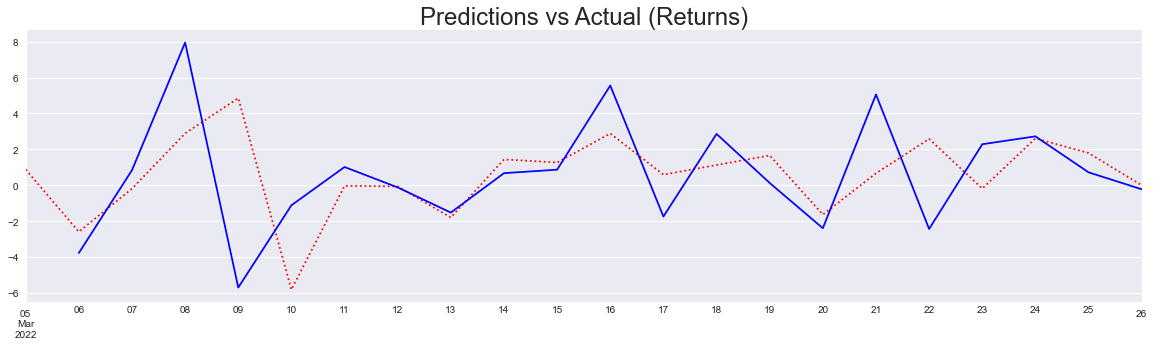

In [72]:
df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, exog = df_test.iloc[:, 1:][start_date:end_date]) 
df_pred_armax[start_date:end_date].plot(figsize = (20,5),linestyle='dotted', color = "red")
df_test.close[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [73]:
results_ret_armax.params

const          0.000028
EMA_S          0.085959
EMA_L         -0.036535
MACD           0.000400
MACD_Signal   -0.000222
vwap           0.945404
K              0.009788
D             -0.010941
SMA_L         -0.002986
SMA_S          0.005396
TH/s          -0.001277
NVDA           0.001523
LTC            0.005326
ETH           -0.002358
ar.L1.close   -0.773349
ar.L2.close   -0.004142
ma.L1.close   -0.227762
ma.L2.close   -0.763275
dtype: float64

In [74]:
results_ret_armax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  close   No. Observations:                 2027
Model:                     ARMA(2, 2)   Log Likelihood               -3385.965
Method:                       css-mle   S.D. of innovations              1.284
Date:                Sat, 26 Mar 2022   AIC                           6809.931
Time:                        08:50:28   BIC                           6916.603
Sample:                    08-17-2016   HQIC                          6849.072
                         - 03-05-2022                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.793e-05      0.000      0.062      0.950      -0.001       0.001
EMA_S           0.0860      0.041      2.085      0.037       0.005       0.167
EMA_L          -0.0365      0.056     -0.651      0.515      -0.147       0.074
MACD            0.0004      0.000      1.963      0.050    5.44e-07       0.001
MACD_Signal    -0.0002      0.000     -1.176      0.239      -0.001       0.000
vwap            0.9454      0.008    111.499      0.000       0.929       0.962
K               0.0098      0.001      9.940      0.000       0.008       0.012
D              -0.0109      0.001     -8.226      0.000      -0.014      -0.008
SMA_L          -0.0030      0.004     -0.792      0.429      -0.010       0.004
SMA_S           0.0054      0.020      0.269      0.788      -0.034       0.045
TH/s           -0.0013      0.001     -0.999      0.318      -0.004       0.001
NVDA            0.0015      0.002      0.815      0.415      -0.002       0.005
LTC             0.0053      0.002      3.283      0.001       0.002       0.009
ETH            -0.0024      0.001     -1.923      0.054      -0.005    4.48e-05
ar.L1.close    -0.7733      0.635     -1.218      0.223      -2.018       0.471
ar.L2.close    -0.0041      0.024     -0.172      0.863      -0.051       0.043
ma.L1.close    -0.2278      0.625     -0.364      0.716      -1.453       0.998
ma.L2.close    -0.7633      0.638     -1.197      0.231      -2.013       0.487
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3022           +0.0000j            1.3022            0.5000
AR.2         -185.3970           +0.0000j          185.3970            0.5000
MA.1            1.0051           +0.0000j            1.0051            0.0000
MA.2           -1.3035           +0.0000j            1.3035            0.5000
-----------------------------------------------------------------------------
"""

### Auto ARIMA

In [75]:
# Longest time this took to run 7 minutes without limiting parameters,
model_auto = auto_arima(df.close, exogenous = df.iloc[:, 1:],m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)

In [76]:
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = len(df_test[start_date:end_date]),
                            exogenous = df_test.iloc[:, 1:][start_date:end_date]),
                            index = df_test[start_date:end_date].index)

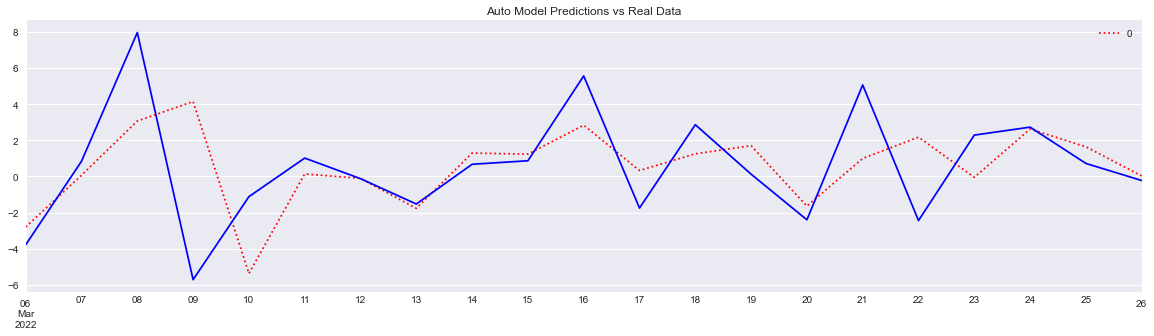

In [77]:
df_auto_pred.plot(figsize = (20,5), color = "red",linestyle='dotted')
df_test.close[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data")
plt.show()

In [78]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 2027
Model:             SARIMAX(2, 0, 4)x(0, 0, [1], 5)   Log Likelihood               -3504.755
Date:                             Sat, 26 Mar 2022   AIC                           7053.511
Time:                                     08:59:14   BIC                           7177.025
Sample:                                 08-17-2016   HQIC                          7098.832
                                      - 03-05-2022                                         
Covariance Type:                               opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -0.0236      0.017     -1.365      0.172      -0.058       0.010
EMA_S           0.5871      0.053     11.094      0.000       0.483       0.691
EMA_L          -0.7990      0.079    -10.150      0.000      -0.953      -0.645
MACD            0.0022      0.000      5.452      0.000       0.001       0.003
MACD_Signal     0.0003      0.000      0.598      0.550      -0.001       0.001
vwap            0.8549      0.008    104.640      0.000       0.839       0.871
K               0.0141      0.001     18.486      0.000       0.013       0.016
D              -0.0122      0.004     -3.462      0.001      -0.019      -0.005
SMA_L           0.0426      0.019      2.246      0.025       0.005       0.080
SMA_S           0.2767      0.031      8.885      0.000       0.216       0.338
TH/s           -0.0033      0.003     -1.171      0.242      -0.009       0.002
NVDA            0.0063      0.008      0.803      0.422      -0.009       0.022
LTC             0.0177      0.004      4.345      0.000       0.010       0.026
ETH             0.0098      0.004      2.625      0.009       0.002       0.017
ar.L1          -0.5630      0.533     -1.056      0.291      -1.608       0.482
ar.L2          -0.5554      0.370     -1.500      0.134      -1.281       0.170
ma.L1          -0.2168      0.535     -0.405      0.685      -1.265       0.831
ma.L2           0.1199      0.446      0.269      0.788      -0.753       0.993
ma.L3          -0.4789      0.285     -1.678      0.093      -1.038       0.080
ma.L4          -0.0229      0.038     -0.607      0.544      -0.097       0.051
ma.S.L5        -0.0240      0.027     -0.890      0.374      -0.077       0.029
sigma2          1.8290      0.032     56.335      0.000       1.765       1.893
===================================================================================
Ljung-Box (L1) (Q):                   1.85   Jarque-Bera (JB):              3331.12
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                             0.23
Prob(H) (two-sided):                  0.17   Kurtosis:                         9.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### SARIMAX

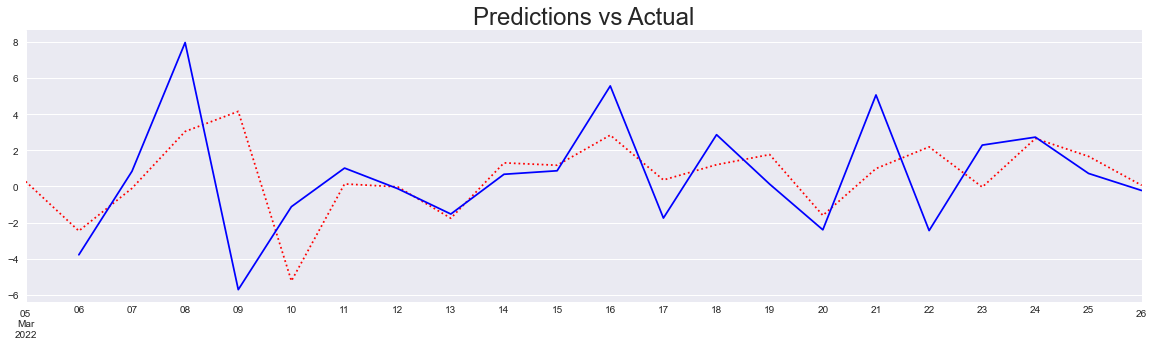

In [79]:
# Plot a Sarimax model, using the p,d,q order provided by the above model summary and view output, will compare later down.
model_ret_sarimax = SARIMAX(df.close, exog = df.iloc[:, 1:], 
                            order = (3,0,2), seasonal_order = (1,0,0,5))
results_ret_sarimax = model_ret_sarimax.fit()

df_pred_sarimax = results_ret_sarimax.predict(start = start_date, end = end_date, 
                                              exog = df_test.iloc[:, 1:][start_date:end_date]) 

df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red",linestyle='dotted')
df_test.close[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

In [80]:
results_ret_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              close   No. Observations:                 2027
Model:             SARIMAX(3, 0, 2)x(1, 0, [], 5)   Log Likelihood               -3499.360
Date:                            Sat, 26 Mar 2022   AIC                           7038.719
Time:                                    08:59:27   BIC                           7151.006
Sample:                                08-17-2016   HQIC                          7079.921
                                     - 03-05-2022                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
EMA_S           0.6060      0.050     12.230      0.000       0.509       0.703
EMA_L          -0.8086      0.072    -11.298      0.000      -0.949      -0.668
MACD            0.0020      0.000      5.455      0.000       0.001       0.003
MACD_Signal     0.0004      0.000      0.908      0.364      -0.000       0.001
vwap            0.8509      0.008    108.041      0.000       0.836       0.866
K               0.0132      0.001     16.727      0.000       0.012       0.015
D              -0.0096      0.003     -3.101      0.002      -0.016      -0.004
SMA_L           0.0281      0.014      2.073      0.038       0.002       0.055
SMA_S           0.2791      0.028     10.088      0.000       0.225       0.333
TH/s         5.836e-05      0.003      0.021      0.984      -0.005       0.006
NVDA            0.0025      0.007      0.353      0.724      -0.012       0.017
LTC             0.0232      0.004      6.605      0.000       0.016       0.030
ETH             0.0047      0.003      1.454      0.146      -0.002       0.011
ar.L1           0.0022     14.309      0.000      1.000     -28.044      28.048
ar.L2          -0.0029      1.406     -0.002      0.998      -2.759       2.753
ar.L3          -0.0029      0.165     -0.017      0.986      -0.327       0.321
ma.L1          -0.7813     14.310     -0.055      0.956     -28.828      27.266
ma.L2          -0.0836     12.557     -0.007      0.995     -24.694      24.527
ar.S.L5         0.0055      0.024      0.229      0.819      -0.042       0.053
sigma2          1.8425      0.033     56.536      0.000       1.779       1.906
===================================================================================
Ljung-Box (L1) (Q):                   3.86   Jarque-Bera (JB):              3342.42
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.27
Prob(H) (two-sided):                  0.13   Kurtosis:                         9.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

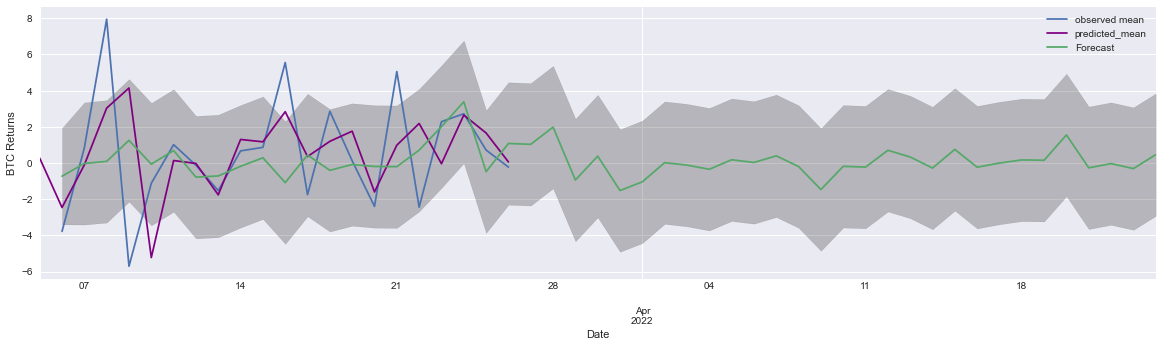

In [81]:
# We will use .get_Forecast to forecast 50 steps (days) into the future
# Plotting the upper bound and lower bound of the forescast in gray
# Plotting the Sarmiax prediction in purple
# Plotting the predicted mean of the get_forecast

pred_uc = results_ret_sarimax.get_forecast(steps=50,signal_only=False,exog = df.iloc[:, 1:][:50])
pred_ci = pred_uc.conf_int()
ax = df_test.close.resample('D').mean().plot(label='observed mean', figsize=(14, 7))
ax = df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "purple")
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('BTC Returns')
plt.legend()
plt.show()

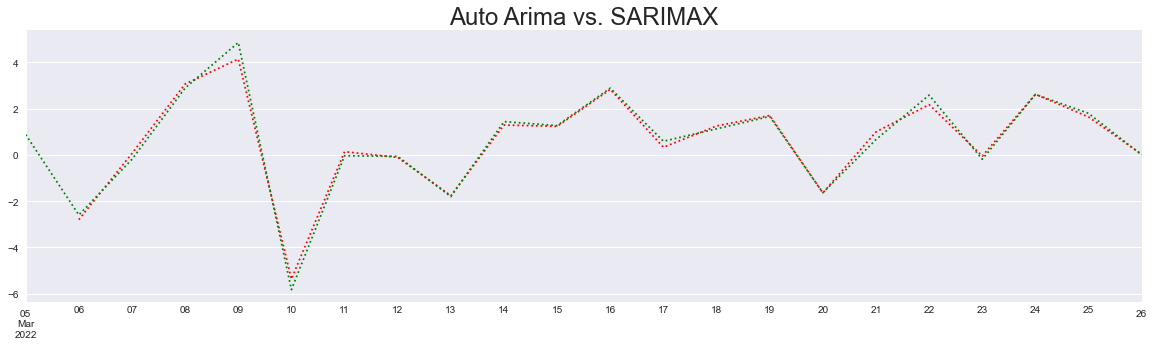

In [82]:
# Plotting Auto-Arima vs ARMAX model, is there efficiency in the Empirical model.
# I.e. 1 by 1 testing common increments in p,d,q on fast running models, 1,0,1 then 2,0,2, or 1,1,1 then 2,2,2
# Vs letting auto arima which does the work for us
df_auto_pred.plot(figsize = (20,5), linestyle='dotted', color = "red",legend=None)
df_pred_armax[start_date:end_date].plot(linestyle='dotted', color = "green",legend=None)
plt.title("Auto Arima vs. SARIMAX", size = 24)
plt.legend = False
plt.show()

### Forecast

In [83]:
pred_ci.tail()

,lower close,upper close
2022-04-20,-1.831406,4.929993
2022-04-21,-3.647419,3.113981
2022-04-22,-3.416254,3.345146
2022-04-23,-3.690309,3.071090
2022-04-24,-2.921710,3.839689


In [84]:
# lets combine our tables, change the column names to be labeled better, 
# and create an Average Upper and lower column that averages the above dataframe
newdf = pd.concat([pred_ci, df_test], axis=1)
newdf = newdf.rename(columns={"close": "returns","lower close": "lower returns","upper close": "upper returns"})
newdf2 = pd.concat([newdf, dfc['close']['2022-03-04':]], axis=1)
newdf2['Average Upper & Lower'] = newdf2[['lower returns', 'upper returns']].mean(axis=1)
newdf2.tail()

,lower returns,upper returns,returns,EMA_S,EMA_L,MACD,MACD_Signal,vwap,K,D,SMA_L,SMA_S,TH/s,NVDA,LTC,ETH,close,Average Upper & Lower
2022-04-20,-1.831406,4.929993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.549293
2022-04-21,-3.647419,3.113981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.266719
2022-04-22,-3.416254,3.345146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.035554
2022-04-23,-3.690309,3.071090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.309610
2022-04-24,-2.921710,3.839689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.458989


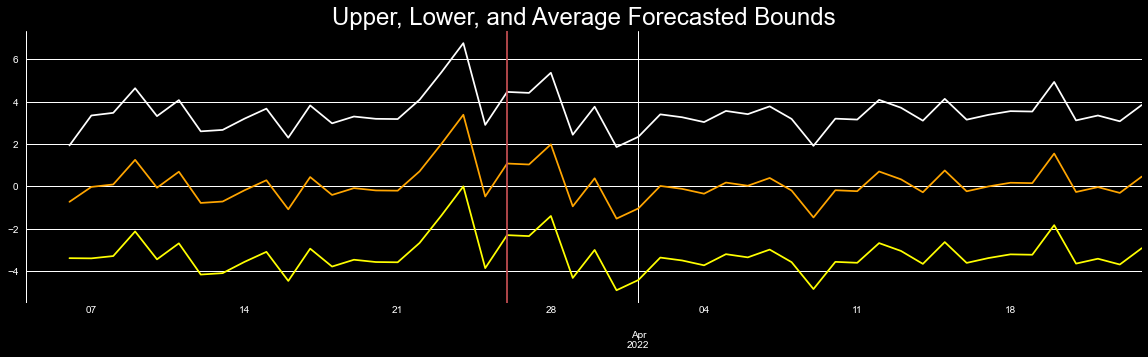

In [89]:
# Lets plot the columns lower, upper, and average columns in dark mode, where the red verticle line represents todays date
newdf2['lower returns'].plot(figsize = (20,5), color = "yellow",legend=None)
newdf2['upper returns'].plot(color = "white",legend=None)
newdf2['Average Upper & Lower'].plot(color = "orange",legend=None)
plt.style.use('dark_background')
plt.title("Upper, Lower, and Average Forecasted Bounds", size = 24)
plt.axvline(pd.Timestamp(end),color='r')
plt.legend = False
plt.show()

In [86]:
# Pull in Future data, a saved csv file with forecasts is preloaded for the conclusion writeup below
future = pd.read_csv("forecastdata.csv", parse_dates = ["Date"], index_col = "Date")
future.index = pd.to_datetime(future.index)
future.index = pd.to_datetime(future.index, format = '%m/%d/%Y').strftime('%Y-%m-%d')
future.tail()

,lower returns,upper returns,returns,EMA_S,EMA_L,MACD,MACD_Signal,vwap,K,D,SMA_L,SMA_S,TH/s,NVDA,LTC,ETH,close,Average Upper & Lower
Date,,,,,,,,,,,,,,,,,,
2022-04-18,-1.845052,4.872647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44391.66456,1.513798
2022-04-19,-3.584694,3.133005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44291.40849,-0.225844
2022-04-20,-3.404052,3.313646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44271.38746,-0.045203
2022-04-21,-3.687214,3.030484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44126.01566,-0.328365
2022-04-22,-2.932847,3.784852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44313.99369,0.426003


In [87]:
# View the data
newdf3 = pd.concat([dfc['close'],future['close'][end:]], axis=0)
display(print("Recalculated BTC Prices"))
newdf3.tail()

Recalculated BTC Prices


None

2022-04-18    44391.66456
2022-04-19    44291.40849
2022-04-20    44271.38746
2022-04-21    44126.01566
2022-04-22    44313.99369
Name: close, dtype: float64

In [88]:
# View the near term forecasts
future[['lower returns','upper returns','Average Upper & Lower']][end:].head()

,lower returns,upper returns,Average Upper & Lower
Date,,,
2022-03-26,-1.389880,5.327818,1.968969
2022-03-27,-4.273157,2.444541,-0.914308
2022-03-28,-2.981783,3.735915,0.377066
2022-03-29,-4.914353,1.803345,-1.555504
2022-03-30,-4.373853,2.343845,-1.015004


### CONCLUSION

The current price of bitcoin is 43,882.90 USD as of 3/24/2022 4:39 PM EST. The model predicts backing into prices from forecasted average log returns that on 4/22/2022 the price of bitcoin will be 44313.99 USD. Representing ~ 0.98% upside.

Near term we probably could say on average returns for days from 3-25 to 3-29 will be between a max of 1.96% and a low of-1.55%, which would seem on average. Near term volatility may be decreasing until the beginning of April.

Regardless of strategy it is apparent that draw down based on each strategy can be volatile, and it maybe benefical to implement more robust strategies, such as combining indicators, or utilizing an alternative strategy

Our models by review of their summary reveal that some of the exogenous factors such as our technical indicators may actually pose signficance in plotting future returns.  However, these returns are only better served in the near term. As returns, and volatility tend to taper off into the future. Other exogenous factors may not be signficiant containing higher P values, and may improve our models fitting by removing specific x factors.

Utilizing an ' Auto - ARIMA' model to optimize the parameters provides us input for p,q,d as well as P,Q,D which can be fed into a SARIMAX model that may provide insight into the future trend of returns. While not directly tracking, near term movements may be reliable when reviewing forecasting data, as no model can account that 50 days from now Elon Musk will tweet Tesla accepts Cardano, Mark Sayler will run for President, or any other factors unknown in the longterm.

However an argument can be made that the '1 by 1' approach to testing by a similar model method in the data set might yield just as good results in faster time.